### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

In [2]:
model_name = 'model-04-lgb-PCA'

### Params

In [3]:
is_log_target = True
is_per_area_target = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [4]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    return df  #, cols_feats

In [5]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [6]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [7]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [8]:
train = pd.read_csv('dataset/train.csv', dtype=object)
test = pd.read_csv('dataset/test.csv', dtype=object)
train.head(5)
test.head(5)

id_cv = []
for i in range(5):
    id_one_fold = pd.read_csv(f'dataset/id_cv{i}.csv', dtype=object)['building_id']
    id_cv.append(id_one_fold)

### Preprocessing

In [9]:
train = pre_processing(train, cols_num, cols_cat)
test = pre_processing(test, cols_num, cols_cat)

c:\python36\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\python36\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### PCA

In [11]:
# get N
n_train = train.shape[0]
n_test = test.shape[0]

# choose cols
cols_pca= [c for c in cols_num if train[c].isnull().sum()==0]
cols_pca.remove('building_per_land_area')
print('Num feats used in pca:', len(cols_pca))

# build combine
combined = pd.concat([train[cols_pca], test[cols_pca]], axis=0)

# fit pca
pca_reducer = PCA(n_components=151)
pca_reducer.fit(combined[cols_pca])

# pca transform
train_pca = pca_reducer.transform(train[cols_pca])

train_pca = pd.DataFrame(train_pca)
train_pca.columns = [f'pca_{i}' for i in range(151)]

train = pd.concat([train, train_pca], axis=1)

test_pca = pca_reducer.transform(test[cols_pca])
test_pca = pd.DataFrame(test_pca)
test_pca.columns = [f'pca_{i}' for i in range(151)]
test = pd.concat([test, test_pca], axis=1)

Num feats used in pca: 151


In [12]:
print(pca_reducer.n_components_)
print(pca_reducer.explained_variance_ratio_)

151
[9.76303560e-01 1.77935367e-02 2.01899113e-03 1.91394195e-03
 1.00397316e-03 4.28972880e-04 2.06159083e-04 1.18075394e-04
 4.91630988e-05 3.42590877e-05 3.12642713e-05 2.64103126e-05
 1.58232322e-05 1.15426139e-05 7.69895335e-06 5.79941847e-06
 4.87068177e-06 4.12608150e-06 3.67806230e-06 2.42179182e-06
 2.06275573e-06 1.94056323e-06 1.56646280e-06 1.25977163e-06
 1.14884617e-06 9.45924166e-07 9.17325975e-07 7.96544264e-07
 5.78674150e-07 5.00605206e-07 4.15025893e-07 4.02426751e-07
 3.80565554e-07 3.11162894e-07 2.77964677e-07 2.50342861e-07
 2.06201940e-07 1.98142655e-07 1.75838951e-07 1.64924881e-07
 1.49780523e-07 1.33932688e-07 1.30505887e-07 1.02312623e-07
 9.67636234e-08 8.45877018e-08 7.41839159e-08 5.76837812e-08
 4.82524757e-08 4.07706665e-08 3.75353991e-08 2.75005514e-08
 2.62259571e-08 2.41353806e-08 2.24862175e-08 1.94194663e-08
 1.71834893e-08 1.55825728e-08 1.45110568e-08 1.30632385e-08
 1.08674140e-08 1.04247535e-08 9.27431819e-09 8.42637188e-09
 7.96387132e-09 7.03

In [13]:
cols_pca = cols_pca

cols_num = set(cols_num) - set(cols_pca) | set([f'pca_{i}' for i in range(151)])
cols_num = list(cols_num)
print(len(cols_num))
print(cols_num)

cols_feats = cols_num + cols_cat

156
['pca_39', 'pca_98', 'pca_81', 'pca_8', 'pca_30', 'pca_24', 'pca_58', 'pca_108', 'pca_101', 'pca_42', 'pca_43', 'pca_9', 'pca_12', 'pca_117', 'pca_71', 'pca_103', 'pca_72', 'pca_50', 'pca_73', 'pca_145', 'pca_120', 'pca_53', 'pca_111', 'village_income_median', 'pca_82', 'pca_99', 'pca_121', 'pca_134', 'txn_floor', 'pca_146', 'pca_115', 'pca_78', 'pca_123', 'pca_127', 'parking_area', 'pca_135', 'pca_48', 'pca_126', 'pca_96', 'pca_55', 'pca_87', 'pca_91', 'pca_17', 'pca_2', 'pca_27', 'pca_45', 'pca_138', 'pca_76', 'pca_16', 'pca_31', 'pca_1', 'pca_70', 'pca_84', 'pca_52', 'pca_0', 'pca_132', 'pca_4', 'pca_19', 'pca_89', 'pca_119', 'pca_49', 'pca_150', 'building_per_land_area', 'pca_139', 'pca_144', 'pca_34', 'pca_57', 'pca_100', 'pca_122', 'pca_133', 'pca_130', 'pca_67', 'pca_80', 'pca_61', 'pca_109', 'pca_33', 'pca_83', 'pca_18', 'pca_95', 'pca_11', 'pca_137', 'pca_90', 'pca_124', 'pca_41', 'pca_37', 'pca_94', 'pca_46', 'pca_47', 'parking_price', 'pca_62', 'pca_10', 'pca_141', 'pca_

### Params

In [14]:
#(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), 
# ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), 
# ('lambda_l2', 0.0)) 
# 5562.8626109379065 0.04307499162341705 0.13229782226230116 0.009940239813132181
# [5544.862518157318, 5568.864484355969, 5574.860830300434]
# [0.042241107856307275, 0.04362114598810233, 0.04336272102584154]
# [0.13198388317748455, 0.13213920963048423, 0.13277037397893476]
# [0.00992134541893296, 0.009911227014286343, 0.00998814700617724]

# params
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'mse',
          'metric': 'mape',
          'learning_rate': 0.01,
          'max_depth': 24,
          'num_leaves': 300,           # may reduce in dim-reduction exp
          'feature_fraction': 0.5,
          'min_data_in_leaf': 5,
          'lambda_l1': 0.1,
          'lambda_l2': 0.0}

lgb_other_params = {'num_boost_round': 100000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000}

### kfold cross-predict

In [15]:
t0 = time.time()

predicts_val = []
predicts_test = test[['building_id']].copy()
best_iterations = []
scores = []
for i, id_fold in enumerate(id_cv):
    #id_fold = id_fold['building_id']
    # split train, val
    df_train = train.loc[~train['building_id'].isin(id_fold)].copy()
    df_val = train.loc[train['building_id'].isin(id_fold)].copy()
    df_test = test.copy()
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    df_test = feat_eng.transform(df_test)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # train model    
    model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
    best_iterations.append(model.best_iteration)

    # Predict on val set
    y_pred = model.predict(df_val[cols_feats])
    mse = mean_squared_error(df_val[col_target], y_pred)
    mae = mean_absolute_error(df_val[col_target], y_pred)
    mape = cal_mape(df_val[col_target], y_pred)
    
    y_pred_final = post_processing(y_pred, df_val)
    score = cal_score(df_val['total_price'], y_pred_final)
    scores.append(score)

    print('(Fold %d) score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (i, score, mse, mae, mape))
    predicts_val.append(pd.DataFrame({'building_id': df_val['building_id'],
                                      'total_price': df_val['total_price'],
                                      'total_price_predict': y_pred_final}))

    # Predict on test set
    y_pred_test = model.predict(df_test[cols_feats])
    predicts_test['target_{}'.format(i)] = y_pred_test

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00987106
[4000]	valid_0's mape: 0.00968402
[6000]	valid_0's mape: 0.00963755
[8000]	valid_0's mape: 0.00961868
[10000]	valid_0's mape: 0.00960795
[12000]	valid_0's mape: 0.00960242
[14000]	valid_0's mape: 0.00959896
[16000]	valid_0's mape: 0.00959802
Early stopping, best iteration is:
[15205]	valid_0's mape: 0.00959801
(Fold 0) score, mse, mae, mape: 5661.86862, 0.04069, 0.12766, 0.00960.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00993613
[4000]	valid_0's mape: 0.00973659
[6000]	valid_0's mape: 0.00968381
[8000]	valid_0's mape: 0.00966275
[10000]	valid_0's mape: 0.00965248
[12000]	valid_0's mape: 0.00964693
[14000]	valid_0's mape: 0.00964364
[16000]	valid_0's mape: 0.0096427
Early stopping, best iteration is:
[15343]	valid_0's mape: 0.0096427
(Fold 1) score, mse, mae, mape: 5726.86732, 0.04250, 0.12821, 0.00963.
Training until validation scores don't i

In [16]:
print('Total run time:', time.time() - t0)

Total run time: 6215.334979772568


In [17]:
print('Kfold cv score (mean, stdev):', np.mean(scores), np.std(scores)) # 5868.87314

Kfold cv score (mean, stdev): 5714.067808369528 31.466489509159597


In [18]:
predicts_test.head()

,building_id,target_0,target_1,target_2,target_3,target_4
0,X5gsdTWGS3W7JJQB,14.989605,15.018842,15.097422,14.913408,14.969521
1,BTshNOJyKHnT2YIT,13.155757,13.140648,13.158698,13.149116,13.152566
2,dhdymr0lV8N5kZOT,13.886511,13.821712,13.852863,13.738501,13.880253
3,VEwyGGMcD56w5BOc,14.803385,14.772607,14.761483,14.790751,14.751549
4,wmUeMoJZfsqaSX9b,12.162801,12.196752,12.144321,12.188068,12.168654


In [19]:
pd.concat(predicts_val, axis=0).to_csv('output/'+model_name+'-cv.csv', index=False)

predicts_test['target_mean'] = \
    predicts_test[['target_'+str(i) for i in range(len(id_cv))]].mean(axis=1)
predicts_test['total_price'] = post_processing(predicts_test['target_mean'].values, df_test)
predicts_test[['building_id', 'total_price']].to_csv('output/'+model_name+'-test-kfold.csv', index=False)

In [20]:
print('Best iterations:', best_iterations)
print('Mean best iterations:', int(np.mean(best_iterations)))

Best iterations: [15205, 15343, 15120, 15304, 15253]
Mean best iterations: 15245


### One-fold test

In [21]:
lgb_other_params_one = {'num_boost_round': int(np.mean(best_iterations)*1.15),
                        'verbose_eval': 2000,}
lgb_other_params_one

{'num_boost_round': 17531, 'verbose_eval': 2000}

In [22]:
params

{'boosting_type': 'gbdt',
 'feature_fraction': 0.5,
 'lambda_l1': 0.1,
 'lambda_l2': 0.0,
 'learning_rate': 0.01,
 'max_depth': 24,
 'metric': 'mape',
 'min_data_in_leaf': 5,
 'num_leaves': 300,
 'objective': 'mse',
 'task': 'train'}

In [23]:
df_train = train.copy()
df_test = test.copy()

# feat eng
feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
df_train = feat_eng.fit_transform(df_train)
df_test = feat_eng.transform(df_test)

# Construct lgb dataset
lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()

# train model    
model = lgb.train(params, lgb_train, valid_sets=lgb_train, **lgb_other_params_one)

y_pred = model.predict(df_test[cols_feats])
y_pred_final = post_processing(y_pred, df_test)

df_test_pred = pd.DataFrame({'building_id': df_test['building_id'], 
                             'total_price': y_pred_final})
display(df_test_pred.head(20))

[2000]	training's mape: 0.00334555
[4000]	training's mape: 0.00172438
[6000]	training's mape: 0.00104967
[8000]	training's mape: 0.000691763
[10000]	training's mape: 0.000481317
[12000]	training's mape: 0.000353196
[14000]	training's mape: 0.000269336
[16000]	training's mape: 0.000212667


,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.162534e+07
1,BTshNOJyKHnT2YIT,4.000835e+06
2,dhdymr0lV8N5kZOT,1.232111e+07
3,VEwyGGMcD56w5BOc,5.991010e+06
4,wmUeMoJZfsqaSX9b,1.129552e+06
5,EtBjGAHmHCe9t7TZ,3.150496e+06
6,hPNH34vmaZtvBtqc,1.224616e+07
7,wXjeI38bYDMJJwZC,6.074603e+06
8,fxZSGX6aPAFKU8W4,1.670035e+06
9,ewr0Fx6ign87OwaV,4.116390e+06


In [24]:
df_test_pred.to_csv('output/'+model_name+'-test-one.csv', index=False)

### Feature importance

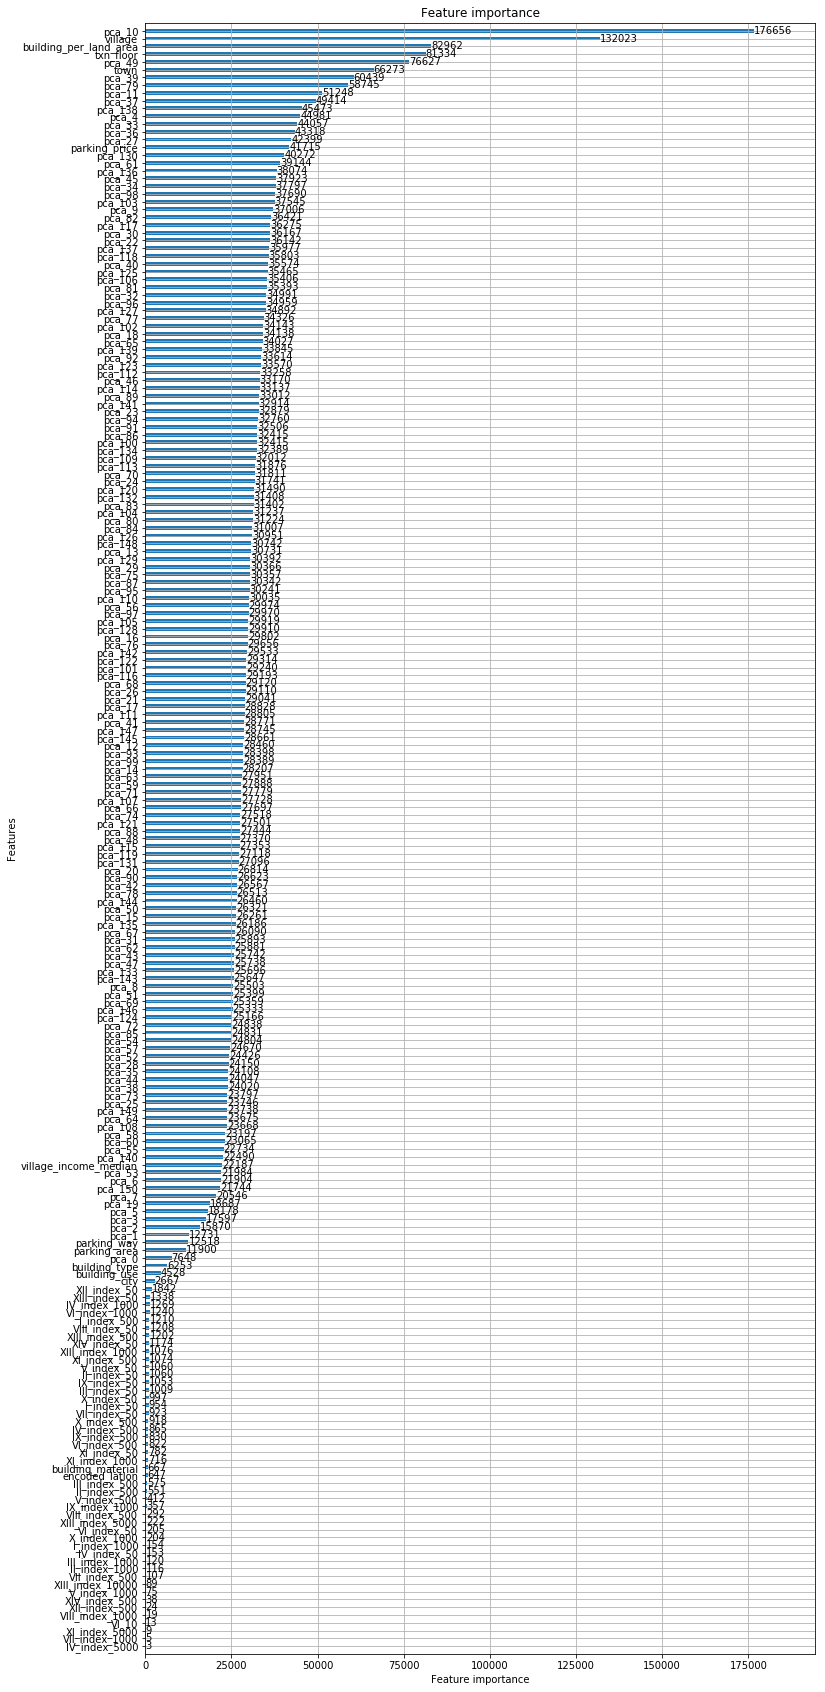

In [25]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

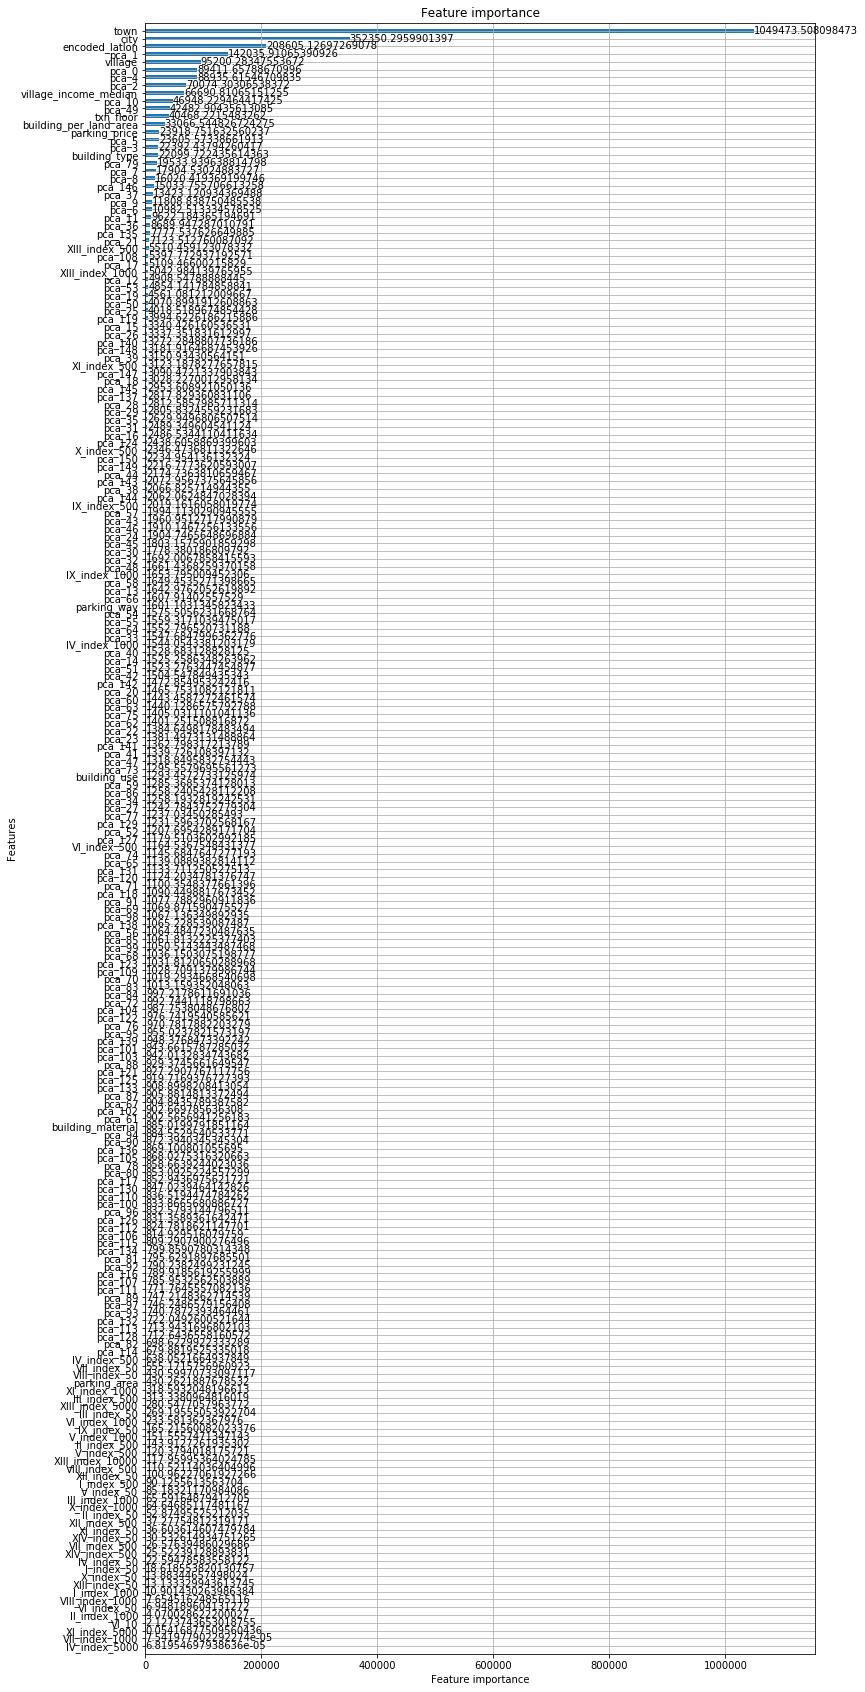

In [26]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()

### LB Result
- kfold:
- one: